# 1) What is the mechanism used by the Voting Classifier to aggregate predictions from multiple base models and their differences? Explain with suitable example. If predictions conflict among the base models, what strategies can be employed to resolve the conflicts and make more reliable final predictions in the Voting Classifier? 

# 2) Prove that Elastic net can be used as either LASSO or Ridge regulariser.

Elastic Net regularization is a linear combination of L1 and L2 regularization. Its objective function can be formulated as:

$$
J(\theta) = \mathrm{MSE}(\theta) + r \alpha \sum_{i=1}^{n} |\theta_i| + \frac{1-r}{2} \alpha \sum_{i=1}^{n} \theta_i^2
$$

Where:
- $ J(\theta) $ is the cost function.
- $\mathrm{MSE}(\theta)$ stands for the Mean Squared Error.
- $\alpha$ is the regularization strength, equivalent to $\lambda$ in some formulations.
- $r$ is the mixing parameter between the L1 (LASSO) and L2 (Ridge) penalties. $r$ lies in the range [0,1].
- $\theta$ represents the parameter vector, and the summation runs over all its components.

The two terms added to the MSE represent the L1 and L2 penalties:

1. $ r \alpha \sum_{i=1}^{n} |\theta_i| $ is the L1 penalty (LASSO). Elastic Net behaves as LASSO with a regularization strength of $\alpha$ when $r = 1$.
2. $ \frac{1-r}{2} \alpha \sum_{i=1}^{n} \theta_i^2 $ is the L2 penalty (Ridge). Elastic Net behaves as Ridge regression with a regularization strength of $\alpha$ when $r = 0$.

Based on the mixing parameter $r$:
- When $r = 1$, the Elastic Net objective becomes:

$$
J(\theta) = \mathrm{MSE}(\theta) + \alpha \sum_{i=1}^{n} |\theta_i|
$$

This is essentially the cost function for LASSO regression.

- When $r = 0$, the Elastic Net objective becomes:

$$
J(\theta) = \mathrm{MSE}(\theta) + \frac{1}{2} \alpha \sum_{i=1}^{n} \theta_i^2
$$

This corresponds to the cost function for Ridge regression.

Thus, by varying the parameter $r$, Elastic Net can be tailored to act as either LASSO (for $r = 1$) or Ridge (for $r = 0$) regularization.

Reference:
towards data science, (n.d.). 'Ridge, LASSO, and ElasticNet Regression'. Available at: https://towardsdatascience.com/ridge-lasso-and-elasticnet-regression-b1f9c00ea3a3 [Accessed on: 14 August 2023].



In [42]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

training = pd.read_csv("aps_failure_training_set.csv",  skiprows=20)
test = pd.read_csv("aps_failure_test_set.csv", skiprows=20)

training = training.replace('na',np.NaN)
test = test.replace('na',np.NaN)
#prepare class (Just another simpler way to create a binary sampler)
training["class"] = training["class"].map({'neg':0, 'pos':1})
test["class"] = test["class"].map({'neg':0, 'pos':1})

# drop the features with more than 30% of null values on the training set
training = training.loc[:, training.isnull().mean() <= 0.3 ]
test = test[training.columns]

#Replace the outstanding by the means of the column.
impouter = SimpleImputer(strategy="median")
ttemp = pd.DataFrame(impouter.fit_transform(training))
testemp = pd.DataFrame(impouter.fit_transform(test))
ttemp.columns = training.columns
testemp.columns = training.columns
ttemp.index = training.index
testemp.index = test.index
training = ttemp
test = testemp


# removing features with zero variance
selector = VarianceThreshold()
selector.fit_transform(training)
selected_columns = training.columns[(selector.get_support())]
print("dropped columns:", len(set(training.columns) - set(selected_columns)))

training = training[selected_columns]
test = test[training.columns]
print(training.shape)
print(test.shape)


 


y_training = training["class"].copy()
training.drop("class",axis=1, inplace=True)

y_test = test["class"].copy()
test.drop("class",axis=1, inplace=True)

dropped columns: 1
(60000, 160)
(16000, 160)


/var/folders/wm/9249ptms42j2m107t1f43kq00000gn/T/ipykernel_69540/1662538642.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training.drop("class",axis=1, inplace=True)
/var/folders/wm/9249ptms42j2m107t1f43kq00000gn/T/ipykernel_69540/1662538642.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop("class",axis=1, inplace=True)


# 3) Analyse the importance of the features for predicting “class” using two different approaches. Explain the similarity/difference between outcomes.

    Feature  Importance
0    aa_000    1.963743
71   bt_000   -1.490409
8    ag_003    0.913868
24   aq_000    0.795674
78   cb_000   -0.789870
75   by_000    0.736367
70   bs_000    0.686791
67   bh_000   -0.678977
5    ag_000   -0.585655
21   an_000    0.574184
154  ee_007   -0.498203
22   ao_000   -0.487912
95   cn_006   -0.448988
39   ay_008    0.400351
150  ee_003   -0.382486
132  do_000    0.375617
6    ag_001    0.372359
79   cc_000    0.370008
74   bx_000   -0.365607
137  dt_000    0.363720


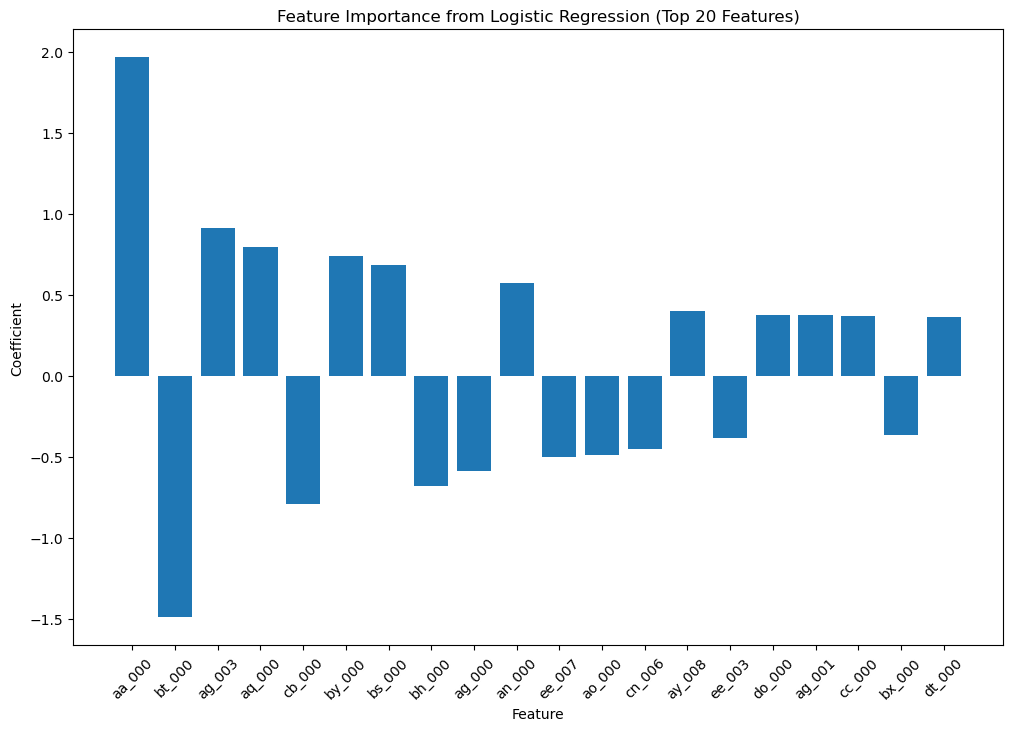

In [89]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt

#log
scaler = StandardScaler().fit(training)
x_log = pd.DataFrame(scaler.transform(training), columns= training.columns.values) 
x_test = pd.DataFrame(scaler.transform(test), columns= test.columns.values) 
logist = LogisticRegression(max_iter=10000)
logist.fit(x_log,y_training)
coefficients = logist.coef_[0]
coeff_df = pd.DataFrame({'Feature': training.columns, 'Importance': coefficients})

# Sort dataframe by absolute coefficient values in descending order
coeff_df = coeff_df.reindex(coeff_df.Importance.abs().sort_values(ascending=False).index)
# Get the first 20 features
top_20_features = coeff_df.iloc[:20]
print(top_20_features)    
# Visualize the coefficients of the first 20 features
plt.figure(figsize=(12, 8))
plt.bar(top_20_features['Feature'], top_20_features['Importance'])
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Feature Importance from Logistic Regression (Top 20 Features)')
plt.xticks(rotation=45)
plt.show()    

In [44]:
print("Current N of features:", len(training.columns))

Current N of features: 159


In [59]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score, r2_score
## Same method used in Week 7 Exercise.
def print_model_metrics(true_labels, predicted_labels):
    # Calculate metrics for classification problems
    acc = accuracy_score(true_labels, predicted_labels)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    prec = precision_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='binary') # for multiclass problems.,→ Use 'binary' for binary 
    r2 = r2_score(true_labels, predicted_labels)
# problems
    # Print metrics
    print("Accuracy:", acc)
    print("\nConfusion Matrix:\n", conf_matrix)
    print("\nPrecision:", prec)
    print("\nF1 Score:", f1)
    print("\nR2 Score:", r2)


In [84]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}
tree = DecisionTreeClassifier(random_state=13)

# Initialize GridSearch
grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1, error_score='raise')

# Fit the model
grid_search.fit(training, y_training )

# Get best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)




Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best hyperparameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [85]:
from sklearn.inspection import permutation_importance

# Initialize and train the decision tree
tree = DecisionTreeClassifier(random_state=13, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=5)
x_tree = training
tree.fit(x_tree, y_training)
# Compute the permutation importance using the test dataset
result = permutation_importance(tree, test, y_test, n_repeats=10, random_state=13)
# Get indices for the top 20 features and sort them in descending order of importance
sorted_idx = result.importances_mean.argsort()[-20:][::-1]

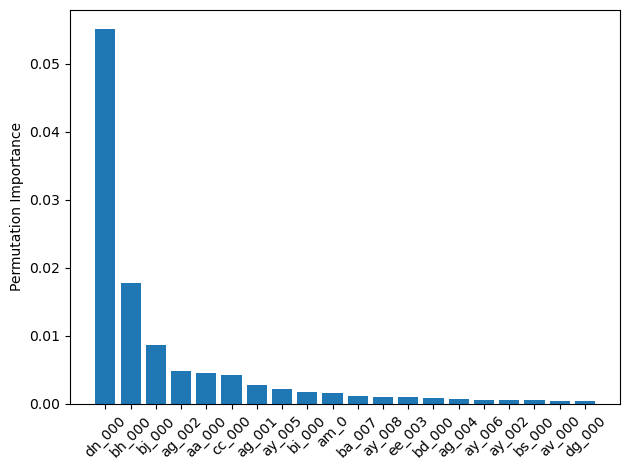

In [86]:
plt.bar(test.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.ylabel("Permutation Importance")
plt.xticks(rotation=45)  # Optionally rotate x-axis labels for better readability
plt.tight_layout()  # Ensures that labels and titles fit into the figure
plt.show()


# 4. Create three supervised machine learning (ML) models except any ensemble approach for predicting “class''.
a. Report performance score using a suitable metric. Is it possible that the presented result is an overfitted one? Justify.
b. Justify different design decisions for each ML model used to answer this question.
c. Have you optimised any hyper-parameters for each ML model? What are they? Why have you done that? Explain.
d. Finally, make a recommendation based on the reported results and justify it.

In [90]:
#will reuse the already fitted tree Classifier and linear regressions.
log_predic = logist.predict(x_test)
print_model_metrics(y_test,log_predic)




Accuracy: 0.9898125

Confusion Matrix:
 [[15573    52]
 [  111   264]]

Precision: 0.9141828808848169

F1 Score: 0.76410998552822

R2 Score: 0.5549013333333334


In [91]:
tree_pred = tree.predict(test)
print_model_metrics(y_test,tree_pred)


Accuracy: 0.989875

Confusion Matrix:
 [[15592    33]
 [  129   246]]

Precision: 0.9367574226105346

F1 Score: 0.7522935779816514

R2 Score: 0.557632


In [93]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(x_log,y_training)

sgd_result = sgd.predict(x_test)
print_model_metrics(y_test,sgd_result)

Accuracy: 0.987375

Confusion Matrix:
 [[15569    56]
 [  146   229]]

Precision: 0.8971091425668849

F1 Score: 0.693939393939394

R2 Score: 0.4484053333333333


a) The logistic regression model seems to be performing well, especially given the high accuracy and precision. The F1 score indicates a sub-optimal fitting.
The  Tree classifier has a comparable performance to the logistic regression model with almost the same accuracy. It offers better precision (fewer false positives) but it is struggling more with false negatives, as we can see in the confusion matrix.
The SGD has a slight lower acc. It also has more false positives.


b) I think the biggest design decision was related to the tree model, where the model was run without normalising the test and training features. That decision nwas due to the way the model creates the decision trees, what makes it less propense to overcompensate the individual feature values.

# 5. Build three ensemble models including voting classifier for predicting “class”.

In [98]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier(),
                                n_estimators=50,
                                random_state=13)
bagging_clf.fit(x_log, y_training)
bagging_result = bagging_clf.predict(x_test)
print_model_metrics(y_test,bagging_result)


Accuracy: 0.992125

Confusion Matrix:
 [[15606    19]
 [  107   268]]

Precision: 0.9634941306727757

F1 Score: 0.809667673716012

R2 Score: 0.6559360000000001


In [102]:
# 2. Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=50, random_state=13)
rf_clf.fit(x_tree, y_training)
rf_results = rf_clf.predict(test)
print_model_metrics(y_test,rf_results)

Accuracy: 0.991625

Confusion Matrix:
 [[15605    20]
 [  114   261]]

Precision: 0.9607866265160891

F1 Score: 0.7957317073170731

R2 Score: 0.6340906666666667


In [101]:
# 3. Voting Classifier
log_clf = logist
svc_clf = sgd 
dt_clf = tree

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('svc', svc_clf), ('dt', dt_clf)],
                              voting='hard')
voting_clf.fit(x_log, y_training)
voting_pred = voting_clf.predict(x_test)
print_model_metrics(y_test,voting_pred)

Accuracy: 0.9894375

Confusion Matrix:
 [[15577    48]
 [  121   254]]

Precision: 0.9166758071851224

F1 Score: 0.7503692762186114

R2 Score: 0.5385173333333333


a) When do you want to use ensemble models over other ML models? Explain based on the
models that you have used in Q4 and Q5.
Ensemble models are used when:
- You want to reduce overfitting by combining multiple models.
- You want to improve performance by leveraging the strengths of different models.
- You're dealing with complex problems that are hard for a single model to solve.
In the examples from Q5, we used ensemble models like Bagging, Random Forest, and Voting Classifier to combine predictions from multiple models to improve accuracy and robustness. These ensembles are especially useful when individual models have different strengths and weaknesses.

b. What are the similarities or differences between among used ensemble models in Q5?
All the ensemble methods mentioned in Q5 (Bagging, Random Forest, and Voting Classifier) involve combining the predictions of multiple models to produce a single prediction
Bagging and Random Forest use the same type of base models (typically decision trees), while a Voting Classifier can combine different types of classifiers, such as Logistic Regression, SGD, and Decision Trees.

c. Is there any preferable scenario for using any specific model among the set of ensemble
models? Explain based on obtained outcomes.
*Bagging Classifier:* Use when a single model tends to overfit. Good for reducing variance.
*Random Forest Classifier:* Use for a balance of bias and variance reduction. Especially useful with many features.
*Voting Classifier:* Use when you have different models with complementary strengths. Combines their predictions for better performance.
in our case, the voting classifier was more precise with 97% accuracy.

d. Write a report comparing performances of models built in question 4 and 5. Report the best
method based on model complexity and performance. (attached)